In [57]:
import librosa
import librosa.feature
import numpy as np

In [58]:
file_path = 'data/i.wav'

In [59]:
x, sr = librosa.load(file_path, sr=None)

In [60]:
# length of the audio signal in seconds
length = librosa.get_duration(y=x, sr=sr)

In [61]:
length

1.25

In [62]:
sr

16000

In [63]:
x.shape

(20000,)

In [64]:
librosa.get_duration(y=x, sr=sr)

1.25

In [65]:
hop_length = int(0.015 * sr)
print('Hop length:', hop_length , 'samples')
frame_length = int(0.03 * sr)
print('Frame length:', frame_length, 'samples')

Hop length: 240 samples
Frame length: 480 samples


In [66]:
energy = np.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

In [67]:
energy.shape

(84,)

# 1. Sử dụng RMSE

In [68]:
rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length, center=True)

In [69]:
rmse.shape

(1, 84)

In [70]:
rmse = rmse[0]

In [71]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

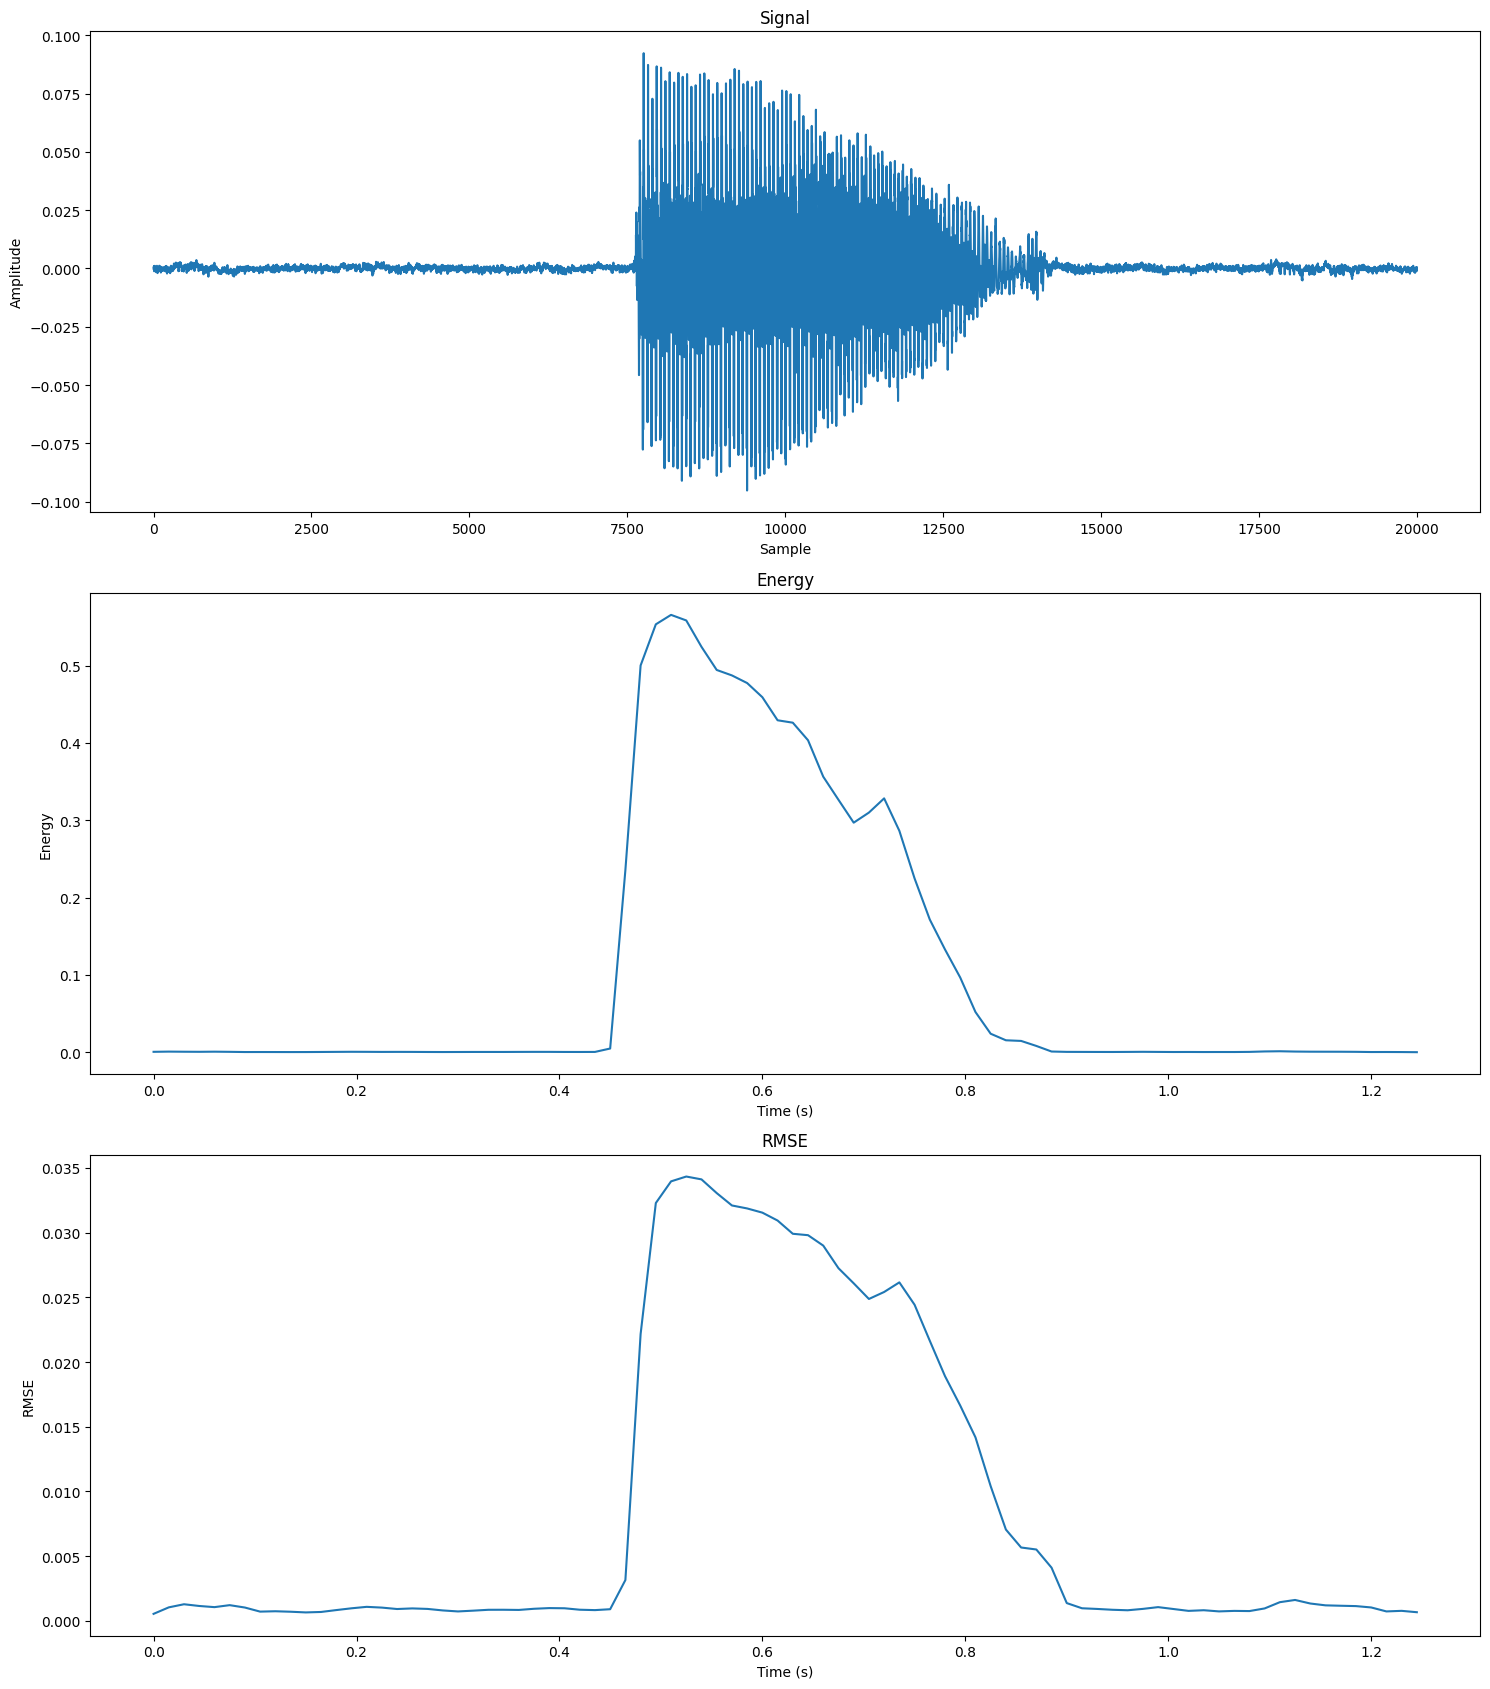

In [72]:
# Plot the signal
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 17))

plt.subplot(3, 1, 1)
plt.plot(x)
plt.title('Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(t, energy)
plt.title('Energy')
plt.xlabel('Time (s)')
plt.ylabel('Energy')

plt.subplot(3, 1, 3)
plt.plot(t, rmse)
plt.title('RMSE')
plt.xlabel('Time (s)')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()


In [73]:
def remove_silent_frames_using_mrse(x, frame_length, hop_length):

    # Tính RMSE
    rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length, center=True)

    # Đặt ngưỡng RMSE
    thresh = 0.005

    # Tạo danh sách các frame mà RMSE >= ngưỡng
    valid_frames = np.where(rmse[0] >= thresh)[0]

    # Nếu không có frame nào thỏa mãn, trả về mảng trống
    if len(valid_frames) == 0:
        return []

    # Tính các chỉ số sample tương ứng với các frame đầu và cuối hợp lệ
    start_sample_index = librosa.frames_to_samples(valid_frames[0], hop_length=hop_length)
    end_sample_index = librosa.frames_to_samples(valid_frames[-1] + 1, hop_length=hop_length)

    # Trả về đoạn âm thanh sau khi loại bỏ các frame không hợp lệ
    return x[start_sample_index:end_sample_index]

In [74]:
y = remove_silent_frames_using_mrse(x, frame_length, hop_length)

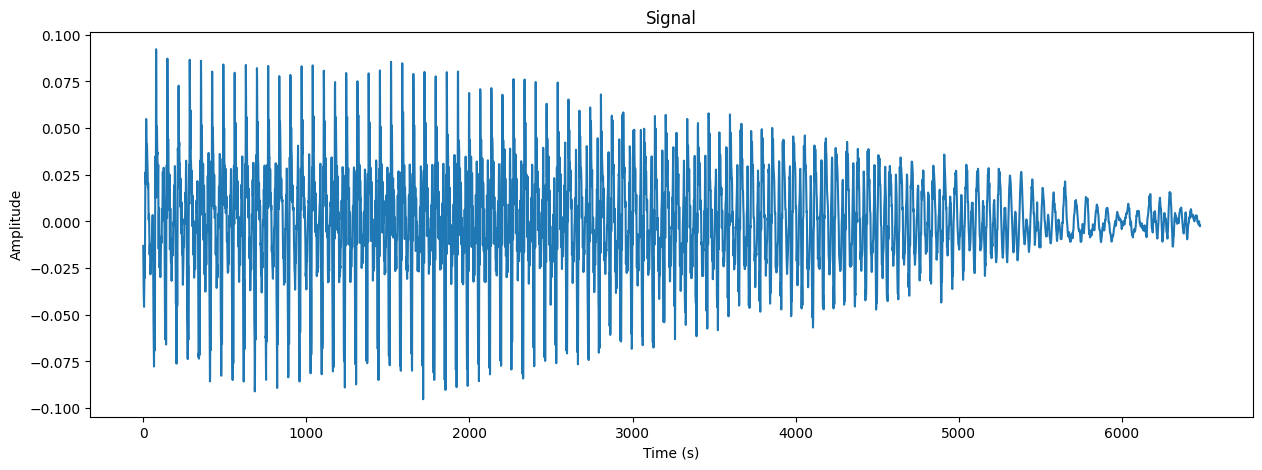

In [75]:
# plot the trimmed signal
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# 2. Chuẩn hóa năng lượng

In [76]:
def remove_silent_frames_using_energy(x: np.ndarray, frame_length, hop_length, thresh=0.1) -> list:
    index_voices = []

    # Tính energy
    energy = np.array([
        sum(abs(x[i:i+frame_length]**2))
        for i in range(0, len(x), hop_length)
    ])

    energy_norm = energy / max(energy)

    # Tạo danh sách các frame index mà energy >= ngưỡng
    for i in range(len(energy)):
        if energy_norm[i] >= thresh:
            index_voices.append(i)

    return index_voices

In [77]:
energy_norm = energy / max(energy)
index_voices = remove_silent_frames_using_energy(x, frame_length, hop_length, thresh=0.05)

In [78]:
def split_segments(index_voices: list) -> list:
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    segments.append((start, index_voices[-1]))
    return segments

In [79]:
segments = split_segments(index_voices)
# skip segment with length < 0.1s
# segments = [(start, end) for start, end in segments if (end - start) * hop_length / sr > 0.1]
segments

[(31, 54)]

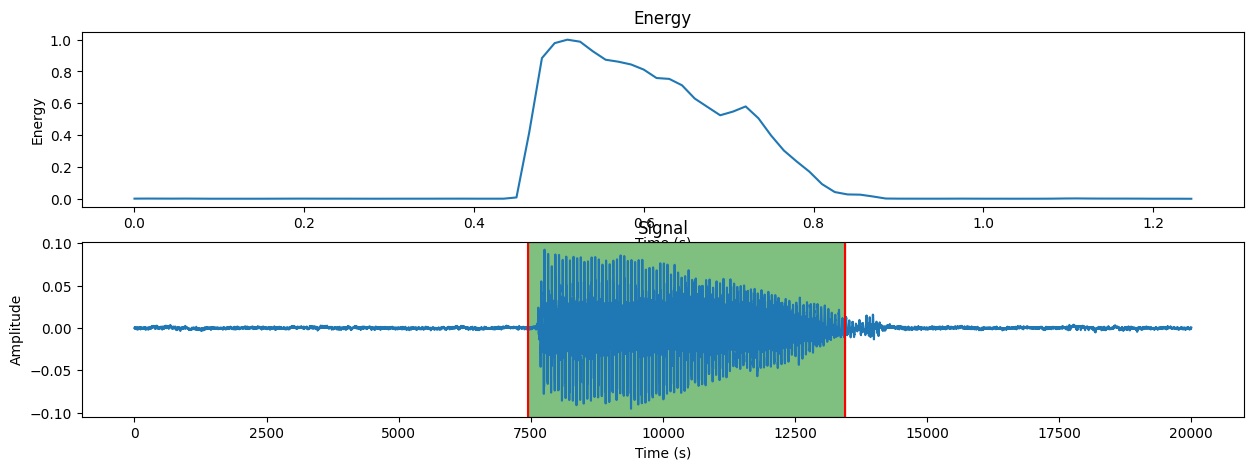

In [80]:
# plot the trimmed signal
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.plot(t, energy_norm)
plt.title('Energy')
plt.xlabel('Time (s)')
plt.ylabel('Energy')

plt.subplot(2, 1, 2)
plt.plot(x)
# Đánh dấu tần số cơ bản (F0) trên đồ thị phổ tần số
for i in segments:
    # define start and end of the segment
    start_sample_index = librosa.frames_to_samples(i[0], hop_length=hop_length)
    end_sample_index = librosa.frames_to_samples(i[1], hop_length=hop_length) + frame_length

    plt.axvline(start_sample_index, color='r')
    # fill the segment with green color
    plt.axvspan(start_sample_index, end_sample_index, color='g', alpha=0.5)
    plt.axvline(end_sample_index, color='r')
    
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [81]:
def autocorrelation(signal):
    result = np.correlate(signal, signal, mode='full')
    mid = len(result) // 2
    return result[mid:]

def find_f0(signal, sr, min_freq=50, max_freq=500):
    ac = autocorrelation(signal)
    # Xác định chỉ số của độ trễ (delay) tương ứng với tần số cơ bản
    ac = ac[int(sr / max_freq):]
    # Tìm chỉ số của độ trễ tối đa
    peak = np.argmax(ac)
    # Tính F0 từ chỉ số độ trễ
    f0 = sr / (peak + int(sr / max_freq))
    
    # Nếu F0 nằm ngoài khoảng cho phép, trả về NaN
    if f0 < min_freq or f0 > max_freq:
        return np.nan
    
    return f0

In [82]:
# khởi tạo f0 cho tất cả các samples của tín hiệu
f0s = np.zeros(len(x))

In [83]:
for i in index_voices:
    start_sample_index = librosa.frames_to_samples(i, hop_length=hop_length)
    end_sample_index = start_sample_index + frame_length
    f0 = find_f0(x[start_sample_index:end_sample_index], sr)
    f0s[start_sample_index:end_sample_index] = f0

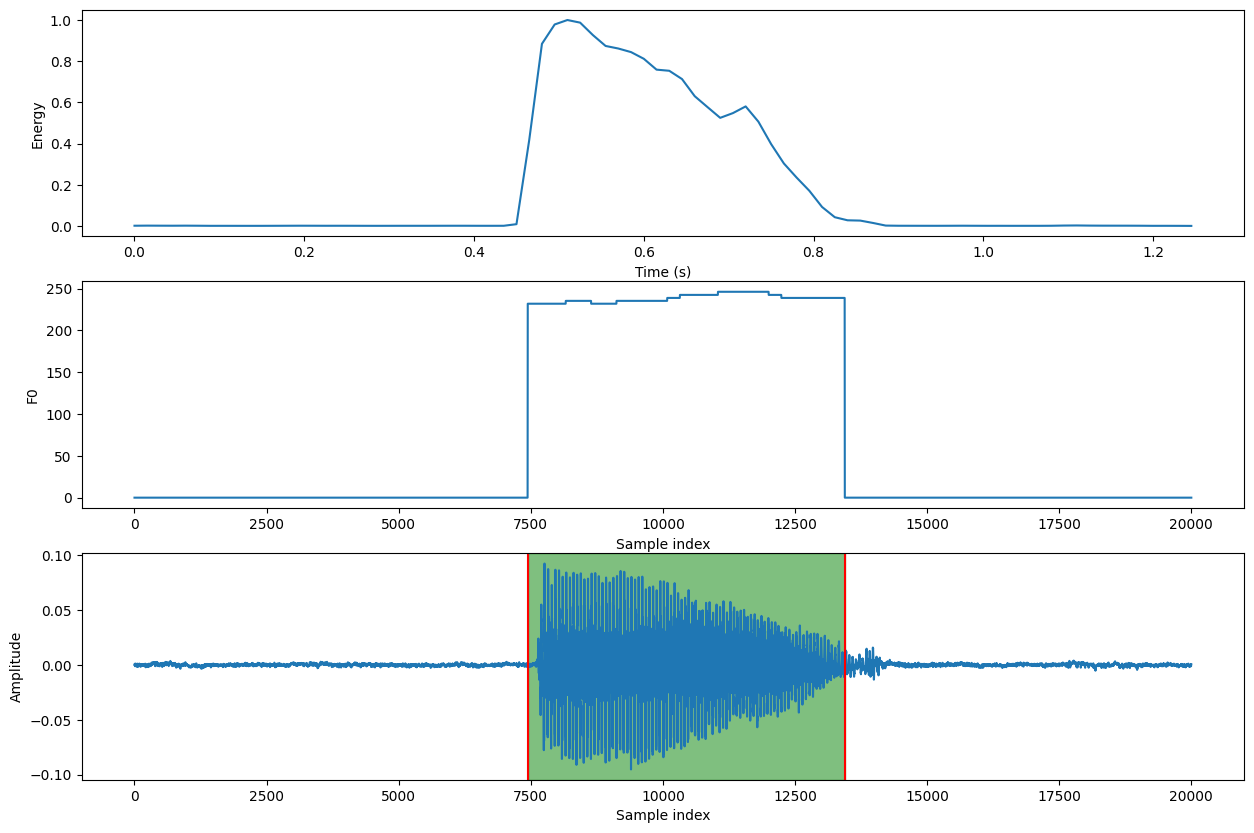

In [84]:
# plot the trimmed signal
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(t, energy_norm)
plt.xlabel('Time (s)')
plt.ylabel('Energy')

plt.subplot(3, 1, 2)
plt.plot(f0s)
plt.xlabel('Sample index')
plt.ylabel('F0')

plt.subplot(3, 1, 3)
plt.plot(x)
# Đánh dấu tần số cơ bản (F0) trên đồ thị phổ tần số
for i in segments:
    # define start and end of the segment
    start_sample_index = librosa.frames_to_samples(i[0], hop_length=hop_length)
    end_sample_index = librosa.frames_to_samples(i[1], hop_length=hop_length) + frame_length

    plt.axvline(start_sample_index, color='r')
    # fill the segment with green color
    plt.axvspan(start_sample_index, end_sample_index, color='g', alpha=0.5)
    plt.axvline(end_sample_index, color='r')
    
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.show()